## RRC Lightkurve Pipeline
### By Eden Schapera

In [1]:
#Import libraries
import lightkurve
import astropy as asp
import numpy as np
import matplotlib.pyplot as plt
from lightkurve.correctors import PLDCorrector
from scipy.signal import argrelmin, argrelmax

In [2]:
# custom mask creation functon
def createCustomAp(w, h, width = 11,height = 11):
    arr = np.zeros((width,height))

    for i in range(h[0],h[1]):
        for ii in range(w[0],w[1]):
            arr[i,ii] = 1
            
    return np.array(arr).astype(bool)

def tpf_2_lc(tpf_collection, amask = []):
    if np.size(amask) == 0:
        lightcurves = [tpf.to_lightcurve(aperture_mask = tpf.create_threshold_mask()) for tpf in tpf_collection]
    else:  
        lightcurves = [tpf.to_lightcurve(aperture_mask = amask) for tpf in tpf_collection]
        
    lightcurve_full = lightcurves[0].append(lightcurves[1:])
    return lightcurve_full

# Moving average function for analysis
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
                   


In [1461]:
#Download target data using RA and DEC (degrees)
name = "S. Ant"

target = "09 32 18.3864862656 -28 37 39.968512032"

lightkurve.search_tesscut(target)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 08,2019,TESScut,1426,09 32 18.3864862656 -28 37 39.968512032,0.0
1,TESS Sector 09,2019,TESScut,1426,09 32 18.3864862656 -28 37 39.968512032,0.0
2,TESS Sector 35,2021,TESScut,475,09 32 18.3864862656 -28 37 39.968512032,0.0
3,TESS Sector 62,2023,TESScut,158,09 32 18.3864862656 -28 37 39.968512032,0.0


C:\ProgramData\Anaconda3\lib\site-packages\lightkurve\search.py:424: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


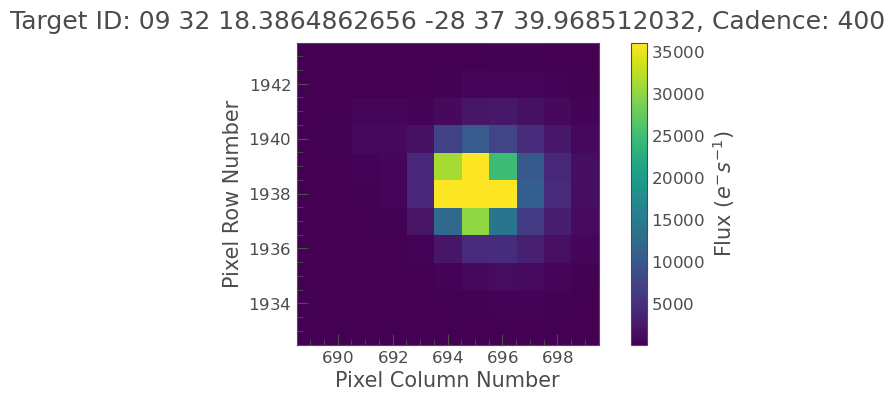

In [1462]:
#download tess data of target, plot example frame
pixelfile = lightkurve.search_tesscut(target).download(cutout_size = (11,11), sector = 66)
pixelfile.plot(frame = 400);

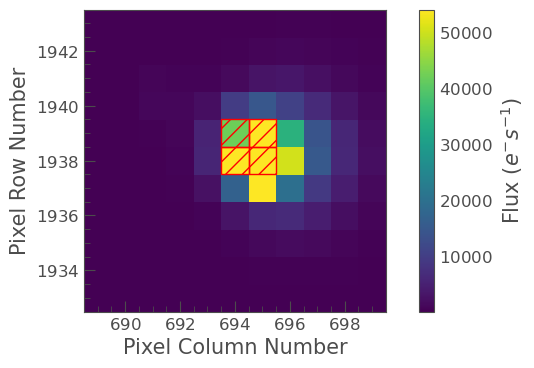

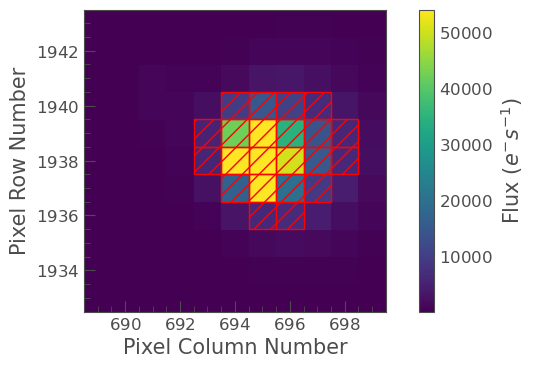

In [1463]:
# create custom masks
cmask=createCustomAp((5,7),(5,7))
tmask = pixelfile.create_threshold_mask(threshold = 10)

#mask array
mask = [cmask, tmask]

# plot masks
# cmask

pixelfile.plot(aperture_mask=mask[0], frame = 40, title="");

# tmask

pixelfile.plot(aperture_mask=mask[1], frame = 40, title="");

Text(0.5, 1.0, 'Uncorrected Lightcurve of S. Ant')

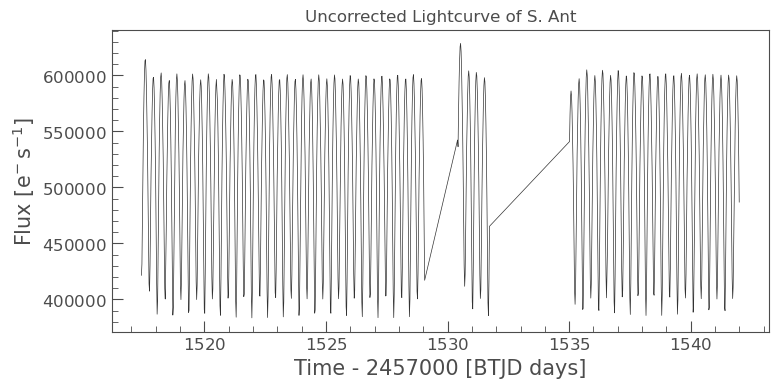

In [1464]:
#Mask selection and removal of null data
aper = mask[1] #Choose mask using index in mask array (above)
lc_full = pixelfile.to_lightcurve(aperture_mask = aper).remove_nans()
lc_full.plot().set_title("Uncorrected Lightcurve of " + name)

In [1465]:
# Use background correction to correct lightcurve
pld = pixelfile.to_corrector('pld',aperture_mask = aper)
corrected_lc = pld.correct(pca_components=1, restore_trend=True)

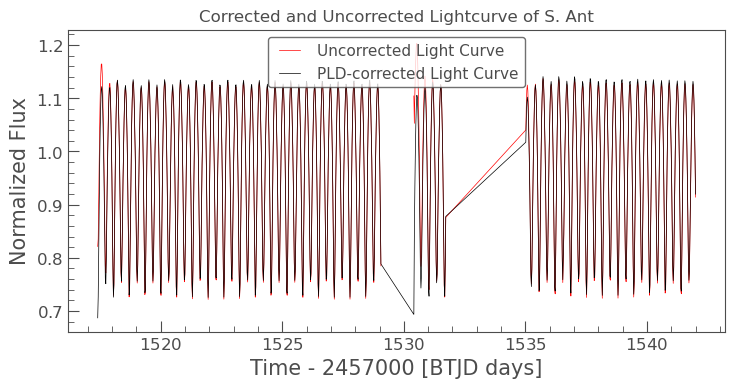

In [1466]:
# Compare corrected and uncorrected lightcurve to compare
uncorrected_lc = pixelfile.to_lightcurve()
ax = uncorrected_lc.normalize().plot(color='red', label='Uncorrected Light Curve');
ax.set_title("Corrected and Uncorrected Lightcurve of " + name)
corrected_lc.normalize().remove_outliers().plot(ax=ax, color='black', label='PLD-corrected Light Curve');

In [1467]:
#Assess variation (error) in lightcurve before and after correction
uncorrected_cdpp = uncorrected_lc.estimate_cdpp()
corrected_cdpp = corrected_lc.estimate_cdpp()
print(f"Uncorrected CDPP = {uncorrected_cdpp:.0f}")
print(f"Corrected CDPP = {corrected_cdpp:.0f}")


Uncorrected CDPP = 29174 ppm
Corrected CDPP = 26613 ppm


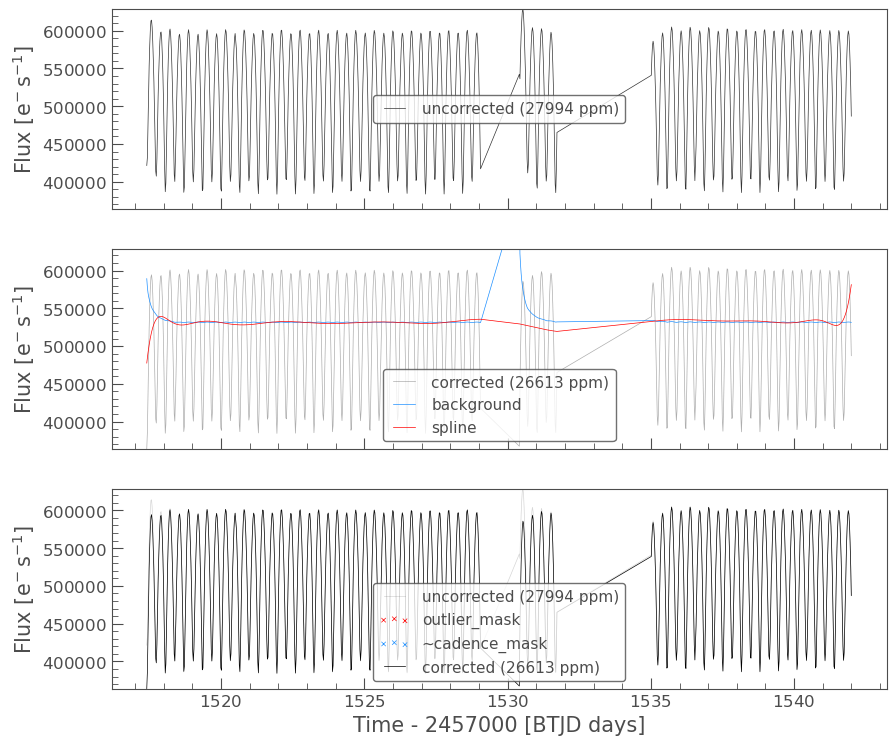

In [1468]:
#Another analysis of correction metrics
pld.diagnose();

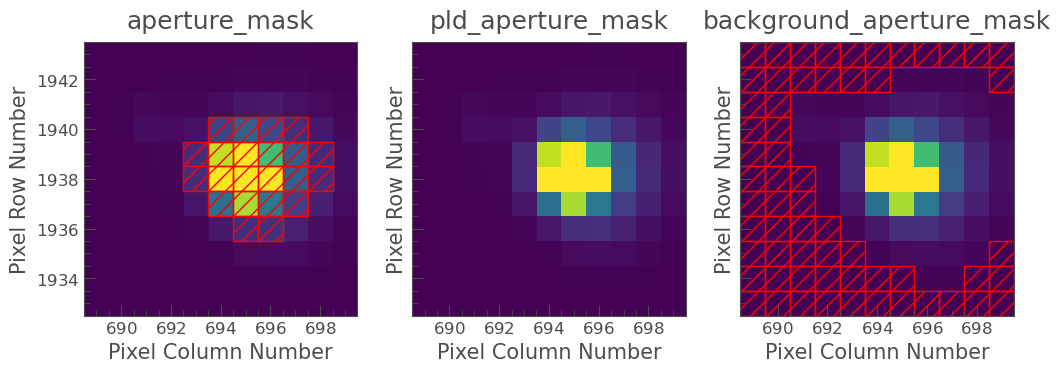

In [1469]:
# Visualize target and background masks
pld.diagnose_masks();

In [1470]:
c_lc = corrected_lc
#c_lc = lc_full

1517.4111302467209


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

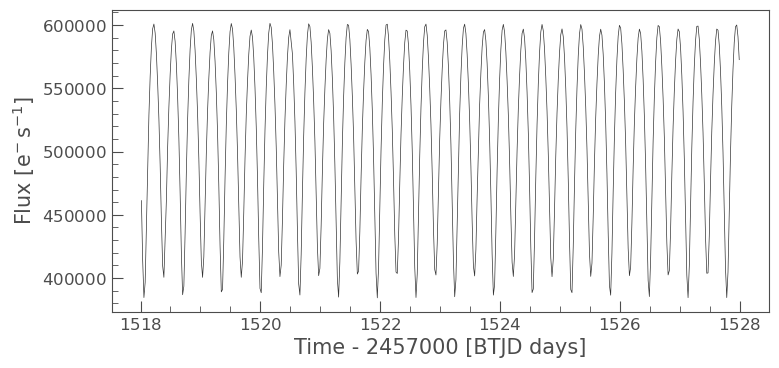

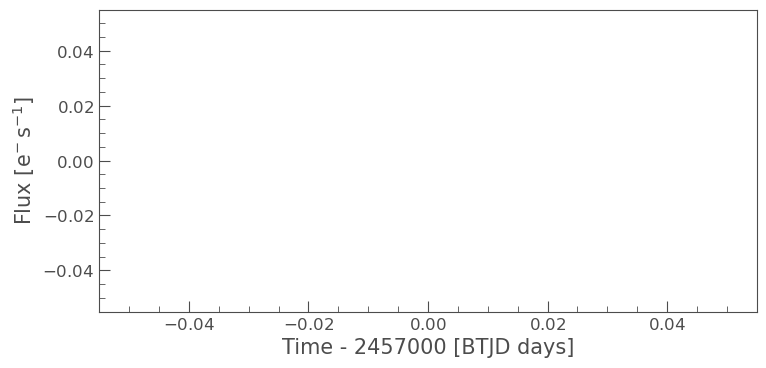

In [1487]:
#Lightcurve slicing to remove errant data that was not eliminated by background correction


times = np.array([float(t.to_string()) for t in c_lc["time"]]) #Make array that is indexable using the time values displayed on screen
t_min = times.min()
t_max = times.max()
print(t_min)
#Uncomment sections to activate slice
#Comment values between which you want to KEEP data
#Uncomment flatten to flatten BEFORE appending


# entire lightcurve
lc_clean1 = c_lc[(times >= np.floor(t_min)) & (times <= np.floor(t_max))].flatten()

# slices of lightcurve
#lc_clean1 = c_lc[(times >= 1518) & (times <= 1528)]#.flatten()
#lc_clean2 = c_lc[(times >= 1585) & (times <= 1594)]#.flatten()
#lc_clean3 = c_lc[(times >= 1792) & (times <= 1800)]#.flatten()
#lc_clean4 = c_lc[(times >= 1804) & (times <= 1812)]#.flatten()

# plot lightcurve slices
lc_clean1.plot()
#lc_clean2.plot()
#lc_clean3.plot()
#lc_clean4.plot()


<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

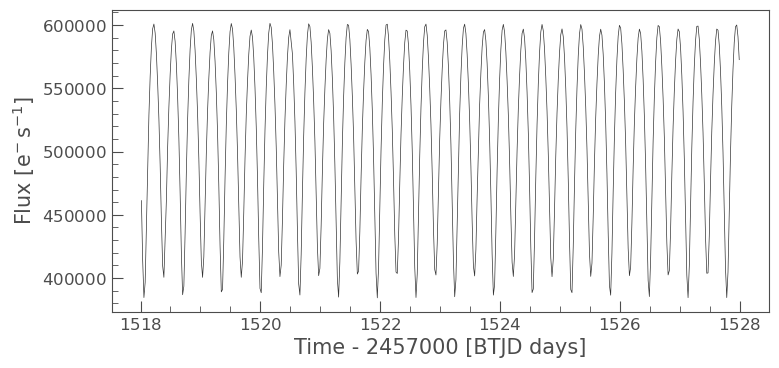

In [1488]:
#Append all data together to make one complete lightcurve
#Uncomment used slices
#lc_t = lc_clean1.append([lc_clean2,
                         #lc_clean3,
                         #lc_clean4
#                        ])

#If only one slice is used, commend out the previous command. Uncomment this line                        ])
lc_t = lc_clean1

lc_t.plot()

lightkurve.Periodogram properties:
      Attribute                      Description               Units
---------------------- --------------------------------------- -----
                nterms                                       1      
          default_view                               frequency      
                 label                                    None      
             ls_method                                    fast      
              targetid 09 32 18.3864862656 -28 37 39.968512032      
frequency_at_max_power                                  3.0864 1 / d
             max_power                             192742.1144   ppm
               nyquist                                 23.9995 1 / d
   period_at_max_power                                   0.324     d
             frequency                           array (1197,) 1 / d
                period                           array (1197,)     d
                 power                           array (1197,)   ppm

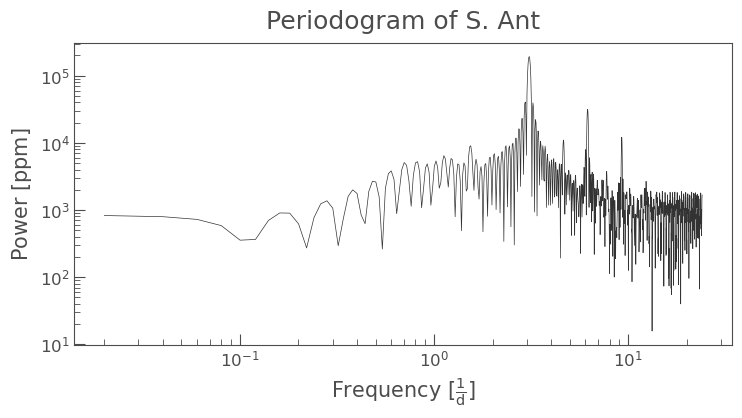

In [1489]:
# create periodogram of lightcurve data, plot in log
pg = lc_t.flatten().normalize(unit='ppm').to_periodogram()
pg.plot(scale = 'log', title = "Periodogram of " + name)

# identify properties of periodogram, period
print(pg.show_properties())
period = pg.period_at_max_power
print("Period = " + str(period))

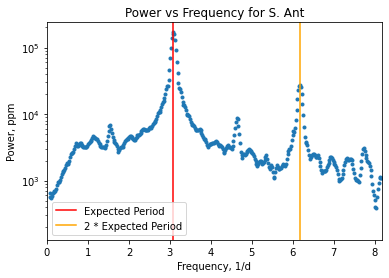

In [1506]:
#Create editable periodogram plot

freqs = pg.frequency
power = pg.power

#Smooth periodogram
freq_av = moving_average(freqs,5)
power_av = moving_average(power,5)


fig, ax = plt.subplots(1)
ax.set_yscale('log')
ax.set_xlim(0,2*pg.frequency_at_max_power.value+2)
ax.set_xlabel("Frequency, 1/d")
ax.set_ylabel("Power, ppm")
ax.set_title("Power vs Frequency for " + name)
ax.plot(freq_av,power_av,'.')

# Vertical lines at dominant frequency and 2x dominant frequency
ax.axvline(x=pg.frequency_at_max_power.value, color = 'red', label = "Expected Period")
ax.axvline(x=2*pg.frequency_at_max_power.value, color = 'orange', label = "2 * Expected Period")
ax.legend(loc = "lower left")


# rendering plot
plt.show()



plt.show()

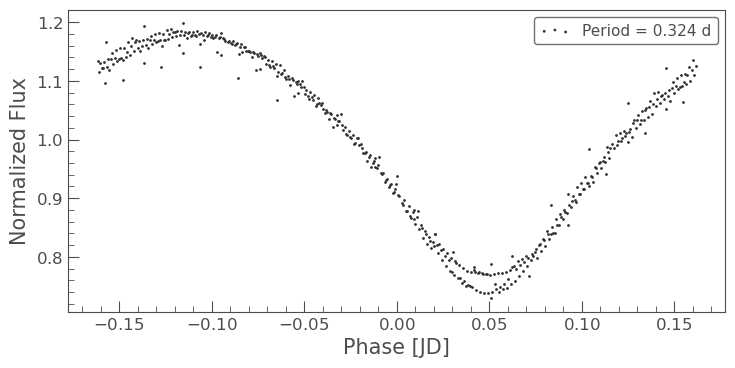

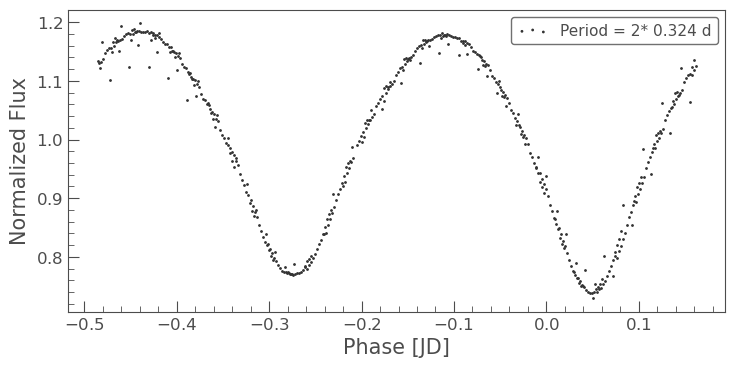

In [1507]:
# fold lightcurve and display along 1 and two periods. 
# rr matches better on 1 period, ecl binary matches better on 2 period 
wp = period/2

lc_t.flatten().fold(period,normalize_phase = False, wrap_phase = wp).scatter(label=f'Period = {period.value:.3f} d');
lc_t.flatten().fold(2*period,normalize_phase = False, wrap_phase = wp).scatter(label=f'Period = 2* {period.value:.3f} d');

[]

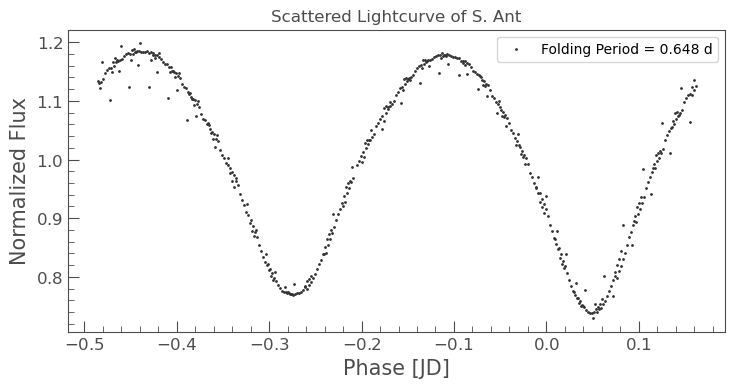

In [1509]:
#Editable graph of the folded, scattered lightcurve
p2 = round(2* period.value, 3)
ax = lc_t.flatten().fold(2*period,normalize_phase = False, wrap_phase = wp).scatter(label=f'Folding Period = {p2} d');
ax.set_title("Scattered Lightcurve of " + name)
ax.legend(loc = "upper right")
ax.plot()

In [1510]:
# Generate pandas dataframe of folded lightcurve
# Uncomment lines to change phase shift
t_pandas = lc_t.flatten().fold(2*period,normalize_phase = False, wrap_phase = wp).to_pandas()
#t_pandas = lc_t.flatten().fold(2*period,normalize_phase = False).to_pandas()

In [1511]:
#Isoate time and flux components of dataframe
flux = t_pandas['flux']
phase_time = t_pandas.index

[]

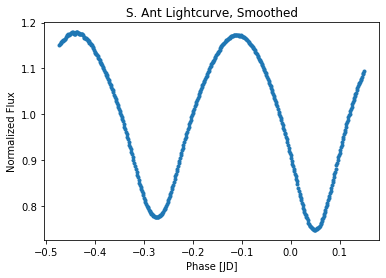

In [1516]:
#Apply smoothing to time and flux. 
time_av = moving_average(phase_time,20)
flux_av = moving_average(flux,20)

# Plot time and flux
fig,ax = plt.subplots(1)
ax.plot(time_av, flux_av,'.',label="Smoothed Lightcurve")
ax.set_title(name +" Lightcurve, Smoothed")
ax.set_xlabel("Phase [JD]")
ax.set_ylabel("Normalized Flux")
#ax.legend()
ax.plot()

In [1527]:
#Identify local minima of flux
# Order can be adjusted to search a wider area around each point
mins = argrelmin(flux_av, order = 20)
flux_mins = flux_av[mins]

#
print("All flux mins: ")
[print(i) for i in flux_mins]
clean_mins= flux_mins[flux_mins < 1.0]
print()

print("Flux mins below 1.0:")
[print(i) for i in clean_mins]
print()

perc_diff = abs(clean_mins[0] - clean_mins[1])
print("Difference between mins: " + str(float(perc_diff)))

All flux mins: 
0.7756423049270207
0.7480821746081237

Flux mins below 1.0:
0.7756423049270207
0.7480821746081237

Difference between mins: 0.027560130318897036


In [1528]:
# Determine whether minima is below RRc threshold
threshold_for_rr = 0.001636354

if(perc_diff < threshold_for_rr):
    print("RR")
else:
    print("Non-RR")

Non-RR
